# Taller 12
Este taller consta de dos punto, los cuales se desarrollarán implementando todo lo que hemos visto en esta y las anteriores clases. 

NOTA: El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller12.ipynb

### Parte 1: 
Seleccionar un modelo pre-entrenado de tensorflow-hub de su preferencia e implementarlo. Explicar en que consiste el modelo seleccionado y realizar un ejemplo para observar el comportamiento de este

### Modelo Seleccionado

El Modelo seleccionado es __YAMNet__, el cual es un modelo que predice que [clases](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) de audios se le ingresa al modelo, teniendo 521 posibles clases de salida.

El modelo fue entrenado con el dataset de [AudioSet-YouTube corpus](http://g.co/audioset) y utiliza una arquitectura  [Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) la cual es una arquitectura convolucional depthwise-separable y se encuentra disponible en [TensorFlowHub](https://tfhub.dev/google/yamnet/1) 

In [41]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd

import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import pathlib

from IPython.display import Audio
from sklearn.model_selection import train_test_split

Se realiza el cargue del modelo pre-entrenado y se realiza una prueba con un audio de ejemplo

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

Se obtienen los nombres de las clases de salida del modelo

In [3]:
def class_names_from_csv(class_map):
    csv_file = tf.io.gfile.GFile(class_map)
    reader = csv.DictReader(csv_file)
    class_names = [row['display_name'] for row in reader]
    return class_names

class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

Se asegura que el audio tenga la forma correcta para ser procesado por el modelo

In [4]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

Se importa un audio de prueba con el maullido de un gato

In [5]:
# Load the sample audio file.
# wav_path = './DataSets/Sample/miaow_16k.wav'
# wav_path = './DataSets/Sample/speech_whistling2.wav'
wav_path = './DataSets/Emotions/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Ensure that the sample rate is set to 16 kHz and calculate the sample length in seconds.
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Show some basic information about the audio.
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Listening to the wav file.
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


Se grafica el audio de prueba

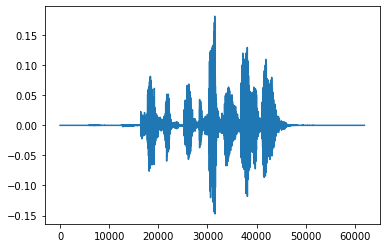

In [6]:
plt.plot(waveform)

Se realiza la predicción del modelo

In [7]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)

# Print the highest-scoring classes and their scores.
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
top_class = scores_np.mean(axis=0).argmax()
infered_class = class_names[top_class]

# results
print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (8, 1024)


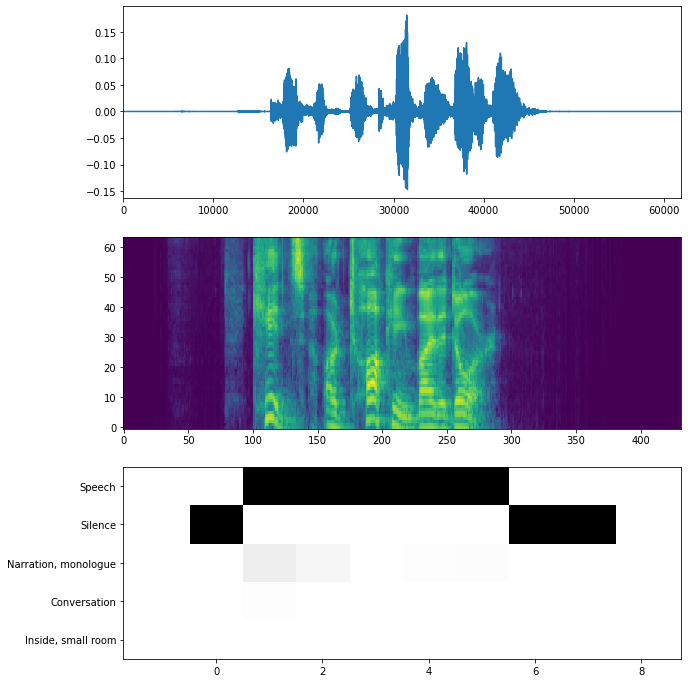

In [8]:
plt.figure(figsize=(10, 12))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 5
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# values from the model documentation
# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])

# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

### Parte 2: 
Seleccionar un modelo pre-entrenado de tensorflow-hub y realizar la estrategia de aprendizaje por transferencia y fine-tuning con datos nuevos, bien sean obtenidos desde internet o generados por usted mismo. 

https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

In [38]:
data_dir = pathlib.Path('./DataSets/ESC-50-master')

In [42]:
esc50_csv = './DataSets/ESC-50-master/meta/esc50.csv'
base_data_path = './DataSets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [67]:
pd_data.category.value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

In [49]:
frame = pd_data[pd_data.category.isin(['dog', 'cat', 'rain', 'cow'])]

In [69]:
audios_dict = {
    'cat': list(base_data_path + frame.loc[frame.category == 'cat'].filename.values),
    'dog': list(base_data_path + frame.loc[frame.category == 'dog'].filename.values),
    'rain': list(base_data_path + frame.loc[frame.category == 'rain'].filename.values),
    'cow': list(base_data_path + frame.loc[frame.category == 'cow'].filename.values),
}

In [68]:
labels_dict = {
    'cat': 0,
    'dog': 1,
    'rain': 2,
    'cow': 3,
}

In [70]:
X, y = [], []

for audio_name, audios in audios_dict.items():
    print(f'Processing {audio_name} audios')
    for audio in audios:
        print('audio: ', audio)
        wav_data, sample_rate = librosa.load(audio)
        waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
        scores, embeddings, spectrogram = yamnet_model(waveform)
        for embedding in embeddings:
            X.append(embedding)
            y.append(labels_dict[audio_name])

Processing cat audios
audio:  ./DataSets/ESC-50-master/audio/1-34094-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-34094-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-47819-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-47819-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-47819-C-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-56380-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-56380-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/1-79113-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-110010-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-110011-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-69131-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-69131-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-82274-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-82274-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-83934-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/2-83934-B-5.wav
audio:  ./DataSets/ESC-50-master/audio/3-146964-A-5.wav
audio:  ./DataSets/ESC-50-master/audio/3

In [71]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((800, 1024), (800,))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.60, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.50, random_state=0)

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(labels_dict.keys()))
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 689,540
Trainable params: 689,540
Non-trainable params: 0
_________________________________________________________________


In [84]:
def print_stadistics(stadistics):
    loss_values = stadistics.history['loss']
    val_loss_values = stadistics.history['val_loss']
    accuracy_values = stadistics.history['accuracy']
    val_accuracy_values = stadistics.history['val_accuracy']

    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.plot(epochs, accuracy_values, 'g', label='Training accuracy')
    plt.plot(epochs, val_accuracy_values, 'y', label='Validation accuracy')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [81]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = "adam",
    metrics = ['accuracy']
)

In [82]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

In [83]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callback
)

Epoch 1/20
15/15 [==============================] - 3s 42ms/step - loss: 0.5419 - accuracy: 0.7833 - val_loss: 0.8813 - val_accuracy: 0.8438
Epoch 2/20
15/15 [==============================] - 0s 21ms/step - loss: 0.3781 - accuracy: 0.8729 - val_loss: 0.3329 - val_accuracy: 0.8500
Epoch 3/20
15/15 [==============================] - 0s 20ms/step - loss: 0.2120 - accuracy: 0.8833 - val_loss: 0.2340 - val_accuracy: 0.8562
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 0.1768 - accuracy: 0.9187 - val_loss: 0.2197 - val_accuracy: 0.8500
Epoch 5/20
15/15 [==============================] - 0s 20ms/step - loss: 0.1555 - accuracy: 0.9000 - val_loss: 0.2368 - val_accuracy: 0.9250
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 0.1445 - accuracy: 0.9083 - val_loss: 0.2205 - val_accuracy: 0.9250
Epoch 7/20
15/15 [==============================] - 0s 23ms/step - loss: 0.1887 - accuracy: 0.9125 - val_loss: 0.2700 - val_accuracy: 0.8500
Epoch 8/20
15

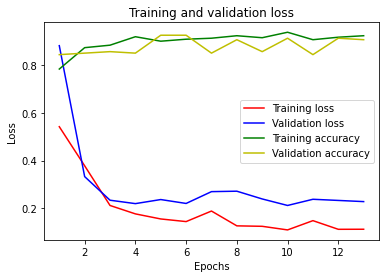

In [85]:
print_stadistics(history)